# Deep learning for timeseries

## Weather Forecasting Using Time Series

---



In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 19:13:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.130.24, 52.217.128.192, 52.216.25.198, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.130.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.48MB/s    in 2.0s    

2024-04-07 19:13:58 (6.48 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

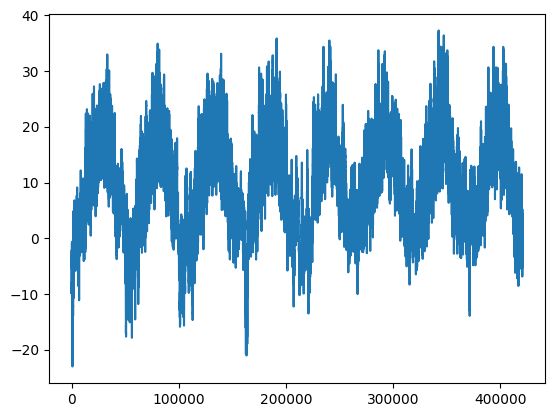

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

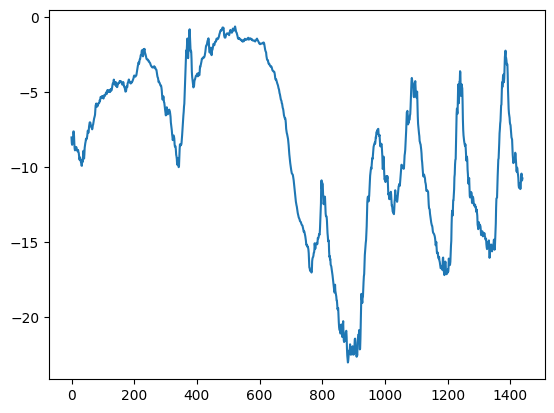

In [6]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


A Basic model with regular calculation has been performed and the validation and test MAE is as follows:

**Validation MAE: 2.44**
**Test MAE: 2.62**

### Initial Learning Model

**Training and evaluating a densely connected model**



*   With two dense layers and 32 units in input layer with relu activation function.
* RMSprop optimizer is chosen for training the model, offering adaptive learning rates.
* Mean Squared Error (MSE) is specified as the loss function, measuring the difference between predicted and actual values.
* Mean Absolute Error (MAE) is defined as a metric to monitor during training, providing insight into the model's performance on the validation set.




In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 14s 15ms/step - loss: 12.9257 - mae: 2.7769 - val_loss: 10.1963 - val_mae: 2.5193
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 8.8879 - mae: 2.3424 - val_loss: 10.5459 - val_mae: 2.5626
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 7.8988 - mae: 2.2121 - val_loss: 10.6927 - val_mae: 2.5782
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 7.2900 - mae: 2.1253 - val_loss: 10.2669 - val_mae: 2.5184
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 6.8256 - mae: 2.0585 - val_loss: 10.6064 - val_mae: 2.5640
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 6.4654 - mae: 2.0064 - val_loss: 11.4330 - val_mae: 2.6682
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 6.1951 - mae: 1.9637 - val_loss: 10.6365 - val_mae: 2.5637
Epoch 8/10
819/819 [==============================] - 

Obtained a test MAE of **2.66** with densely connected model


**Plotting results**

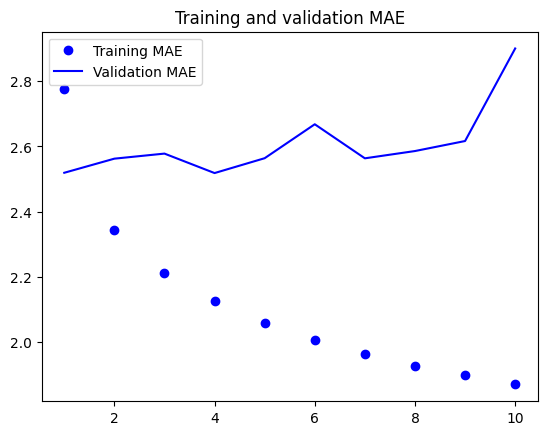

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 15ms/step - loss: 20.7243 - mae: 3.5699 - val_loss: 14.9074 - val_mae: 3.0464
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 14.8947 - mae: 3.0652 - val_loss: 16.6134 - val_mae: 3.2512
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 13.7372 - mae: 2.9385 - val_loss: 15.3188 - val_mae: 3.1015
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 12.8121 - mae: 2.8361 - val_loss: 14.3146 - val_mae: 2.9733
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 12.1851 - mae: 2.7649 - val_loss: 17.4674 - val_mae: 3.3305
Epoch 6/10
819/819 [==============================] - 13s 15ms/step - loss: 11.6864 - mae: 2.7055 - val_loss: 15.5787 - val_mae: 3.1278
Epoch 7/10
819/819 [==============================] - 13s 15ms/step - loss: 11.3239 - mae: 2.6610 - val_loss: 13.2942 - val_mae: 2.8637
Epoch 8/10
819/819 [============================

test MAE is 3

**A simple LSTM-based model**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 16ms/step - loss: 35.4203 - mae: 4.3277 - val_loss: 11.5558 - val_mae: 2.6177
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 10.7983 - mae: 2.5491 - val_loss: 10.0128 - val_mae: 2.4705
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 9.8068 - mae: 2.4400 - val_loss: 9.8804 - val_mae: 2.4508
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 9.4433 - mae: 2.3926 - val_loss: 10.2112 - val_mae: 2.4743
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 9.2311 - mae: 2.3639 - val_loss: 9.9840 - val_mae: 2.4520
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 9.0896 - mae: 2.3439 - val_loss: 9.9822 - val_mae: 2.4470
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 8.9466 - mae: 2.3208 - val_loss: 9.9594 - val_mae: 2.4454
Epoch 8/10
819/819 [==============================] - 13s

A basic baseline RNN was built using LSTM and the test MAE has improved to 2.62

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [17]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

# 1. Adjusting the number of units in each recurrent layer in the stacked setup

### Using SimpleRNN in Keras

**Stacking RNN layers**



*   Stacked SimpleRNN layers with increasing units ( 64, 64) process sequential data.
* RMSprop optimizer is used with Mean Squared Error (MSE) loss and Mean Absolute Error (MAE) metric.



In [18]:
steps = 120
num_features = 32
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.SimpleRNN(64, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_simple_rnn.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 15s 16ms/step - loss: 9.4512 - mae: 2.3926 - val_loss: 10.0122 - val_mae: 2.4584
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 9.2482 - mae: 2.3661 - val_loss: 9.9653 - val_mae: 2.4521
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 9.0741 - mae: 2.3385 - val_loss: 10.1225 - val_mae: 2.4689
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 8.9353 - mae: 2.3178 - val_loss: 9.9965 - val_mae: 2.4501
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 8.8258 - mae: 2.3042 - val_loss: 10.1064 - val_mae: 2.4578
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 8.7061 - mae: 2.2873 - val_loss: 10.3653 - val_mae: 2.4900
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 8.6319 - mae: 2.2760 - val_loss: 10.2307 - val_mae: 2.4856
Epoch 8/10
819/819 [==============================] - 13s

In [19]:
model = keras.models.load_model("jena_simple_rnn.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 5s 10ms/step - loss: 11.8930 - mae: 2.6204
Test MAE: 2.62


* A simpleRNN with two layer has a MAE of 2.62  

# 2. Using layer_lstm() instead of layer_gru()

### Stacking RNNs with GRU and LSTM

**stacked GRU model with dropout regularisation**


*   Two stacked GRU layers are employed, with 64 units in the first layer and 64 units in the second layer.
* The second GRU layer is followed by a dropout layer with a dropout rate of 0.4 to prevent overfitting.
*   The model is compiled using the RMSprop optimizer, Mean Squared Error (MSE) loss function, and Mean Absolute Error (MAE) metric.



In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(64, return_sequences=True)(inputs)
x = layers.GRU(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 22s 22ms/step - loss: 16.5217 - mae: 3.0445 - val_loss: 9.2017 - val_mae: 2.3616
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 10.6773 - mae: 2.5473 - val_loss: 8.7767 - val_mae: 2.3098
Epoch 3/10
819/819 [==============================] - 17s 21ms/step - loss: 9.2854 - mae: 2.3773 - val_loss: 9.8569 - val_mae: 2.4495
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 7.9209 - mae: 2.1904 - val_loss: 10.6808 - val_mae: 2.5429
Epoch 5/10
819/819 [==============================] - 18s 21ms/step - loss: 6.7189 - mae: 2.0106 - val_loss: 11.0721 - val_mae: 2.5835
Epoch 6/10
819/819 [==============================] - 18s 21ms/step - loss: 5.8137 - mae: 1.8639 - val_loss: 11.3959 - val_mae: 2.6161
Epoch 7/10
819/819 [==============================] - 17s 21ms/step - loss: 5.1514 - mae: 1.7483 - val_loss: 12.4523 - val_mae: 2.7198
Epoch 8/10
819/819 [==============================] - 17

* Using GRU stacked RNN the test MAE is **2.46**.


**Using LSTM and dropout regularisation**

* This model comprises two LSTM (Long Short-Term Memory) layers. The first layer has 64 units, followed by a second layer with 64 units.
* A dropout layer with a dropout rate of 0.5 is inserted between the two LSTM layers. Dropout is effective for regularizing the model and reducing overfitting by randomly dropping 50% of the units during training.
* The model is compiled using the RMSprop optimizer, a robust optimizer for training recurrent neural networks.
* Mean Squared Error (MSE) is chosen as the loss function to measure the difference between predicted and actual values.
* Mean Absolute Error (MAE) is selected as a metric to monitor during training, providing insight into the model's performance on the validation set.

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 22ms/step - loss: 15.8535 - mae: 2.9781 - val_loss: 10.5154 - val_mae: 2.5569
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 8.6692 - mae: 2.2781 - val_loss: 12.0460 - val_mae: 2.6972
Epoch 3/10
819/819 [==============================] - 18s 21ms/step - loss: 6.8376 - mae: 2.0015 - val_loss: 12.8804 - val_mae: 2.7921
Epoch 4/10
819/819 [==============================] - 17s 21ms/step - loss: 5.7614 - mae: 1.8239 - val_loss: 12.2712 - val_mae: 2.7226
Epoch 5/10
819/819 [==============================] - 17s 21ms/step - loss: 5.0237 - mae: 1.6934 - val_loss: 13.3621 - val_mae: 2.8594
Epoch 6/10
819/819 [==============================] - 18s 21ms/step - loss: 4.4981 - mae: 1.5971 - val_loss: 13.4103 - val_mae: 2.8595
Epoch 7/10
819/819 [==============================] - 17s 21ms/step - loss: 4.1514 - mae: 1.5284 - val_loss: 13.4073 - val_mae: 2.8708
Epoch 8/10
819/819 [==============================] - 

* With LSTM, the test MAE is 2.63


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 19s 19ms/step - loss: 26.4161 - mae: 3.7042 - val_loss: 10.7981 - val_mae: 2.5559
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.5371 - mae: 2.4142 - val_loss: 9.8833 - val_mae: 2.4341
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 8.5709 - mae: 2.2838 - val_loss: 9.8581 - val_mae: 2.4395
Epoch 4/10
819/819 [==============================] - 15s 19ms/step - loss: 7.9988 - mae: 2.2052 - val_loss: 9.7590 - val_mae: 2.4161
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.4943 - mae: 2.1336 - val_loss: 9.7918 - val_mae: 2.4288
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.0928 - mae: 2.0778 - val_loss: 9.9425 - val_mae: 2.4526
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 6.8505 - mae: 2.0421 - val_loss: 10.5840 - val_mae: 2.5636
Epoch 8/10
819/819 [==============================] - 15s 1

# 3. Using a combination of 1d_convnets and RNN.

* A conv 1D stacked with RNN LSTM

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(16, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_conv_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 18.1233 - mae: 3.2465 - val_loss: 13.5285 - val_mae: 2.8887
Epoch 2/10
819/819 [==============================] - 14s 16ms/step - loss: 12.0821 - mae: 2.7072 - val_loss: 12.0003 - val_mae: 2.7064
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 10.3257 - mae: 2.4817 - val_loss: 12.2284 - val_mae: 2.7292
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 9.1538 - mae: 2.3195 - val_loss: 12.4800 - val_mae: 2.7763
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 8.2843 - mae: 2.1920 - val_loss: 13.3008 - val_mae: 2.8780
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 7.4953 - mae: 2.0828 - val_loss: 13.1701 - val_mae: 2.8480
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 6.8518 - mae: 1.9908 - val_loss: 14.0784 - val_mae: 2.9663
Epoch 8/10
819/819 [==============================] 

In [23]:
model = keras.models.load_model("jena_lstm_conv_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 5s 11ms/step - loss: 13.7845 - mae: 2.9190
Test MAE: 2.92


With combination of conv1d and RNN lstm, the model got worsened with test MAE 2.92.

## Summary

In this study focused on time series forecasting of temperature using the Jena Climate dataset, various neural network architectures were explored and evaluated. The dataset, covering climatic observations from 2009 to 2016 in Jena, Germany, was divided into training, validation, and test sets to ensure reliable model evaluation.

A baseline model, predicting temperature using the mean of the training data, was established for comparison. This simplistic approach provided a benchmark for assessing the effectiveness of more complex models.

Several neural network designs were investigated:

**Densely Connected Model:** A straightforward model with one dense layer achieved a good test Mean Absolute Error (MAE) of 2.66, demonstrating solid performance despite its simplicity.

**1D Convolutional Model:** Utilizing three 1D convolutional layers with max-pooling, this model leveraged the capabilities of convolutional neural networks (CNNs). However, it exhibited a higher test MAE of 3, indicating inferior performance compared to the densely connected model.

**Recurrent Neural Networks (RNNs):** Different RNN topologies were explored, including a simple RNN model with two stacked layers and increasing units, achieving a reduced MAE of 2.62, demonstrating better performance.

**Stacked Gated Recurrent Unit (GRU) Model:** Incorporating dropout regularization to prevent overfitting, this model achieved an outstanding test MAE of 2.46, indicating superior performance.

**Long Short-Term Memory (LSTM) Model:** Stacked LSTM layers with dropout regularization yielded a test MAE of 2.63, showing poorer performance compared to the GRU model.

**Combination of 1D Convolution and RNN:** A hybrid model combining LSTM and 1D convolutional layers with dropout regularization aimed to leverage the strengths of both architectures. However, it performed worse than the stacked GRU and LSTM models, with a test MAE of 2.92.

In summary, the study showcased the effectiveness of recurrent neural network architectures, particularly the stacked GRU model, which demonstrated superior performance in forecasting temperature from historical climate data. These findings highlight the importance of selecting appropriate neural network designs tailored to the specific characteristics of the time series data for accurate forecasting.